In [15]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 3.0 MB/s eta 0:00:0000:0100:01


In [75]:
import argparse
import json
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Define la función euclidean_distance si no está definida
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [78]:
def load_gaze_data(file_path):
    df = pd.read_csv(file_path)
    df["current_time"] = pd.to_datetime(
        df["current_time"], format="%Y-%m-%dT%H:%M:%S.%fZ"
    )
    return df


def load_json_data(file_path):
    with open(file_path, "r") as file:
        json_data = json.load(file)
    return json_data


def process_gaze_data(df, json_data):
    # Step 1: initial date and first time
    initial_date = datetime.strptime(
        json_data[0]["initialDate"], "%Y-%m-%dT%H:%M:%S.%fZ"
    )
    last_time_seconds = df[df["current_time"] - initial_date < timedelta(seconds=0)]
    if last_time_seconds.empty:
        less = df["current_time"].loc[0]
        last_time_seconds = -abs(less - initial_date).total_seconds()
    else:
        last_time_seconds = last_time_seconds["time_seconds"].iloc[-1]

    # Step 2: Remove all rows where `time_seconds` is less than 0
    df["time_seconds"] = df["time_seconds"] - last_time_seconds
    df = df[df["time_seconds"] >= 0].reset_index(drop=True)
    df["postID"] = None

    # Step 3: Assign postID based on PostStartTime and PostEndTime
    for obj in json_data:
        post_start_time = obj["PostStartTime"]
        post_end_time = obj["PostEndTime"]
        post_id = obj["postID"]

        df.loc[
            (df["time_seconds"] >= post_start_time)
            & (df["time_seconds"] <= post_end_time),
            "postID",
        ] = post_id

    # Step 4: Remove all rows where `postID` is None
    df = df[df["postID"].notna()].reset_index(drop=True)
    print("dataframe filtered", df)
    return df


def process_screenshots(screenshots_folder, json_data):

    # Step 1: Get the list of screenshot files
    screenshot_files = os.listdir(screenshots_folder)
    screenshot_files = [file for file in screenshot_files if file.endswith(".png")]
    screenshot_assignments = []

    # Step 2: Assign postID based on screenshot timestamp
    for file in screenshot_files:
        timestamp_str = (
            file.replace("screenshot_", "").replace(".png", "").replace("_", ":")
        )
        screenshot_time = datetime.strptime(timestamp_str, "%Y-%m-%dT%H:%M:%S")
        assigned_post_id = None
        for obj in json_data:
            initial_date = datetime.strptime(
                obj["initialDate"], "%Y-%m-%dT%H:%M:%S.%fZ"
            )
            post_start_time = initial_date + timedelta(seconds=obj["PostStartTime"])
            post_end_time = initial_date + timedelta(seconds=obj["PostEndTime"])

            if post_start_time <= screenshot_time <= post_end_time:
                assigned_post_id = obj["postID"]
                break

        screenshot_assignments.append(
            {
                "filename": file,
                "screenshot_time": screenshot_time,
                "postID": assigned_post_id,
            }
        )

    # Step 3: Create a DataFrame with the assignments
    screenshot_df = pd.DataFrame(screenshot_assignments)
    screenshot_df = screenshot_df[screenshot_df["postID"].notna()].reset_index(
        drop=True
    )
    screenshot_df = screenshot_df.drop_duplicates(subset="postID", keep="first")
    screenshot_df.sort_values(by="screenshot_time", inplace=True)
    return screenshot_df


def assign_screenshot_filenames(df, screenshot_df):
    screenshot_df["postID"] = screenshot_df["postID"].astype(int)
    postID_to_filename = screenshot_df.set_index("postID")["filename"].to_dict()
    df["screenshot_filename"] = df["postID"].map(postID_to_filename)
    return df


def save_split_files(df, output_folder, name):
    os.makedirs(output_folder, exist_ok=True)
    unique_post_ids = df["postID"].unique()

    for post_id in unique_post_ids:
        df_filtered = df[df['postID'] == post_id]
        filename = f'{name}_gaze_{post_id}.csv'
        df_filtered["x"] = df_filtered["x"].astype(int)
        df_filtered["y"] = df_filtered["y"].astype(int)
        df_filtered.to_csv(os.path.join(output_folder, filename), index=False)

    print(f"Archivos CSV creados en la carpeta {output_folder}")


def create_heatmaps(unique_post_ids, width, height, name, root):
    for post_id in unique_post_ids:
        df_file = pd.read_csv(root + f"gaze_posts/{name}_gaze_{post_id}.csv")
        input_csv = root + f"gaze_posts/{name}_gaze_{post_id}.csv"
        image_screenshot = (
            root + f"screenshots/{df_file['screenshot_filename'].iloc[0]}"
        )

        new_screenshot_filename = f"{name}_screenshot_{post_id}.png"

        # Assuming the screenshot is stored initially with its original name and needs renaming
        new_screenshot_path = root + f"screenshots/{new_screenshot_filename}"

        if os.path.exists(image_screenshot):
            os.rename(image_screenshot, new_screenshot_path)

        output_scan = f"scanpath/{name}_scanpath_{post_id}.png"
        os.system(
            f"python scripts/scanpath.py {input_csv} {new_screenshot_path} {output_scan}"
        )
        

        # os.system(
        #     f"python scripts/gazeheatplot.py {input_csv} {width} {height} -b {image_screenshot} -o {heatmap_file}"
        # )


def main():
    name = "isidora"

    root = f""
    input_file = root + "gaze_clean.csv"
    json_file = root + f"times/{name}_posts_times.json"
    screenshot_folder = root + "screenshots/"

    df = load_gaze_data(input_file)
    json_data = load_json_data(json_file)
    df = process_gaze_data(df, json_data)
    screenshot_df = process_screenshots(screenshot_folder, json_data)
    df = assign_screenshot_filenames(df, screenshot_df)
    save_split_files(df, root + "gaze_posts/", name)
    unique_post_ids = df["postID"].unique()

    create_heatmaps(unique_post_ids, width=1920, height=1080, name=name, root=root)




In [79]:
main()

dataframe filtered            x       y  time_seconds            current_time postID
0      714.0   526.0      0.264000 2024-06-22 19:40:26.112     19
1      711.0   531.0      0.280661 2024-06-22 19:40:26.128     19
2      716.0   530.0      0.297322 2024-06-22 19:40:26.143     19
3      722.0   535.0      0.313981 2024-06-22 19:40:26.175     19
4      724.0   539.0      0.330641 2024-06-22 19:40:26.191     19
...      ...     ...           ...                     ...    ...
22869  643.0  1085.0    495.953298 2024-06-22 19:48:41.807      6
22870  646.0  1091.0    495.969953 2024-06-22 19:48:41.822      6
22871  649.0  1093.0    495.986607 2024-06-22 19:48:41.840      6
22872  654.0  1091.0    496.003262 2024-06-22 19:48:41.854      6
22873  647.0  1103.0    496.019917 2024-06-22 19:48:41.870      6

[22874 rows x 5 columns]


ValueError: time data 'isidora:12' does not match format '%Y-%m-%dT%H:%M:%S'

In [30]:
import pandas as pd
import cv2

# Load the gaze data
gaze_csv = 'gaze_posts/isidora_gaze_6.csv'
image = 'screenshots/screenshot_2024-06-22T19_48_33.png'
gaze_data = pd.read_csv(gaze_csv)
# Load the background image
background_image = cv2.imread(image)

# Video parameters
output_video = 'gaze_scanpath_video.mp4'
frame_size = (background_image.shape[1], background_image.shape[0])
fps = 120  # Increase FPS to make the video shorter

# Initialize the video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, frame_size)

# Function to draw the scanpath up to the current point
def draw_scanpath(img, gaze_points, current_idx):
    img_copy = img.copy()
    for i in range(current_idx):
        cv2.circle(img_copy, (int(gaze_points[i][0]), int(gaze_points[i][1])-30), 8, (0, 0, 255), -1)  # Increase circle radius
        if i > 0:
            cv2.line(img_copy, (int(gaze_points[i-1][0]), int(gaze_points[i-1][1])-30), 
                     (int(gaze_points[i][0]), int(gaze_points[i][1])-30), (0, 0, 255), 2)
    return img_copy

# Generate frames
gaze_points = gaze_data[['x', 'y']].values
for i in range(len(gaze_points)):
    frame = draw_scanpath(background_image, gaze_points, i + 1)
    video_writer.write(frame)

# Release the video writer
video_writer.release()

print(f'Video saved as {output_video}')


Video saved as gaze_scanpath_video.mp4


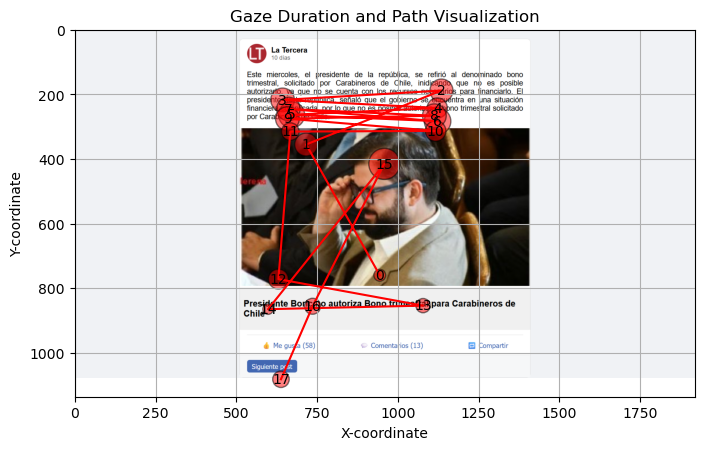

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

import math
gaze_csv = 'gaze_posts/isidora_gaze_6.csv'
image_path = 'screenshots/screenshot_2024-06-22T19_48_33.png'

# Example data (replace with your actual data loading code)

data = pd.read_csv(gaze_csv)
image = plt.imread(image_path)

x = data['x']
y = data['y']


# Inicializa la trama
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image)

# Umbral para el radio (ajusta este valor según sea necesario)
radius = 450

# Variables para rastrear el último punto trazado y el tiempo
last_x = data['x'].iloc[0]
last_y = data['y'].iloc[0]
accumulated_time = 0
start_time = data['time_seconds'].iloc[0]

# Listas para almacenar los puntos y tiempos
plot_x = []
plot_y = []
times = []
last_time = max(data['time_seconds'])

# Bucle a través de los datos
last_take = False
for i in range(1, len(data)):
    dist = euclidean_distance(last_x, last_y, data['x'].iloc[i], data['y'].iloc[i])
    if last_time - data['time_seconds'].iloc[i] < 0.5 and not last_take:
        plot_x.append(last_x)
        plot_y.append(last_y)
        times.append(accumulated_time if accumulated_time > 0 else 1)  # Evitar log(0)
        last_x = data['x'].iloc[i]
        last_y = data['y'].iloc[i]
        start_time = data['time_seconds'].iloc[i]
        accumulated_time = 0
        last_take = True
        continue

    if dist <= radius:
        accumulated_time += (data['time_seconds'].iloc[i] - start_time)
    else:
        plot_x.append(last_x)
        plot_y.append(last_y)
        times.append(accumulated_time if accumulated_time > 0 else 1)  # Evitar log(0)
        last_x = data['x'].iloc[i]
        last_y = data['y'].iloc[i]
        start_time = data['time_seconds'].iloc[i]
        accumulated_time = 0

# Agregar el último punto y su tiempo
plot_x.append(last_x)
plot_y.append(last_y)
times.append(accumulated_time if accumulated_time > 0 else 1)  # Evitar log(0)

# Normalizar los tiempos para determinar los tamaños de los círculos
max_time = max(times) if max(times) > 0 else 1  # Asegurarse de que max_time no sea cero
sizes = [math.log(time) / math.log(max_time) * 500 for time in times]  # Ajustar el tamaño de los círculos

# Trazar los puntos y las líneas
ax.plot(plot_x, plot_y, marker='', linestyle='-', color='red')
scatter = ax.scatter(plot_x, plot_y, s=sizes, c='red', alpha=0.5, edgecolors='black')

# Anotar puntos con el tiempo acumulado, centrado en el círculo
for i, (px, py, time) in enumerate(zip(plot_x, plot_y, times)):
    ax.annotate(i, (px, py), textcoords="offset points", xytext=(0,0), ha='center', va='center', color='black')

ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_title('Gaze Duration and Path Visualization')
ax.grid(True)

save_path = "scanpath/{name}_scanpath_{postID}.jpg"
plt.
plt.show()

In [64]:
# Función de actualización para la animación
def update(frame):
    global last_x, last_y, start_time, accumulated_time, scatter
    
    # Calcular distancia y tiempo acumulado
    dist = euclidean_distance(last_x, last_y, data['x'].iloc[frame], data['y'].iloc[frame])
    if dist <= radius:
        accumulated_time += (data['time_seconds'].iloc[frame] - start_time)
    else:
        if accumulated_time > 0:  # Solo añadir si hay tiempo acumulado
            plot_x.append(last_x)
            plot_y.append(last_y)
            times.append(max(1, accumulated_time))  # Evitar log(0)
            # Normalizar y calcular el tamaño del círculo
            size = math.log(times[-1]) / math.log(max(times)) * 500
            if scatter is not None:
                scatter.remove()
            scatter = ax.scatter(plot_x, plot_y, s=[size], c='red', alpha=0.5, edgecolors='black')
            ax.annotate(f'{times[-1]:.2f}s', (last_x, last_y), textcoords="offset points", xytext=(0,0), ha='center', va='center', color='black')

        # Resetear para el nuevo punto
        last_x = data['x'].iloc[frame]
        last_y = data['y'].iloc[frame]
        start_time = data['time_seconds'].iloc[frame]
        accumulated_time = 0

# Variables iniciales
last_x = data['x'].iloc[0]
last_y = data['y'].iloc[0]
accumulated_time = 0
start_time = data['time_seconds'].iloc[0]
radius = 450  # Ajusta este valor según sea necesario

# Crear la animación
ani = FuncAnimation(fig, update, frames=len(data), repeat=False)

# Guardar la animación
ani.save('gaze_path_animation.mp4', writer='ffmpeg', fps=1000)

plt.show()

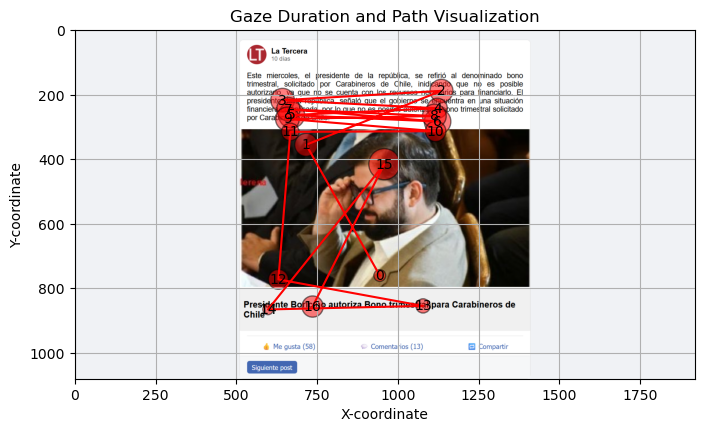

In [51]:

# Inicializa la trama
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(image)

# Umbral para el radio (ajusta este valor según sea necesario)
radius = 450

# Variables para rastrear el último punto trazado y el tiempo
last_x = data['x'].iloc[0]
last_y = data['y'].iloc[0]
accumulated_time = 0
start_time = data['time_seconds'].iloc[0]

# Listas para almacenar los puntos y tiempos
plot_x = []
plot_y = []
times = []

# Bucle a través de los datos
for i in range(1, len(data)):
    dist = euclidean_distance(last_x, last_y, data['x'].iloc[i], data['y'].iloc[i])
    if dist <= radius:
        accumulated_time += (data['time_seconds'].iloc[i] - start_time)
    else:
        plot_x.append(last_x)
        plot_y.append(last_y)
        times.append(accumulated_time if accumulated_time > 0 else 1)  # Evitar log(0)
        last_x = data['x'].iloc[i]
        last_y = data['y'].iloc[i]
        start_time = data['time_seconds'].iloc[i]
        accumulated_time = 0

# Agregar el último punto y su tiempo
plot_x.append(last_x)
plot_y.append(last_y)
times.append(accumulated_time if accumulated_time > 0 else 1)  # Evitar log(0)

# Normalizar los tiempos para determinar los tamaños de los círculos
max_time = max(times) if max(times) > 0 else 1  # Asegurarse de que max_time no sea cero
sizes = [math.log(time) / math.log(max_time) * 500 for time in times]  # Ajustar el tamaño de los círculos

# Trazar los puntos y las líneas
ax.plot(plot_x, plot_y, marker='', linestyle='-', color='red')
scatter = ax.scatter(plot_x, plot_y, s=sizes, c='red', alpha=0.5, edgecolors='black')

# Anotar puntos con el tiempo acumulado, centrado en el círculo
for i, (px, py, time) in enumerate(zip(plot_x, plot_y, times)):
    ax.annotate(i, (px, py), textcoords="offset points", xytext=(0,0), ha='center', va='center', color='black')

ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_title('Gaze Duration and Path Visualization')
ax.grid(True)
plt.show()

In [71]:
import cv2
import pandas as pd
import numpy as np

import cv2
import pandas as pd
import numpy as np
import math

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def plot_gaze_cv2(data_csv, image_path, output_video_path, radius=450, fps=30):
    # Cargar datos y la imagen
    data = pd.read_csv(data_csv)
    image = cv2.imread(image_path)
    height, width, layers = image.shape

    # Configurar la salida de video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Inicializar variables
    last_x, last_y = data['x'].iloc[0], data['y'].iloc[0]
    accumulated_time = 0
    start_time = data['time_seconds'].iloc[0]
    last_time = data['time_seconds'].iloc[0]
    last_take = False
    value = 1
    for i in range(1, len(data)):
        frame = image.copy()
        x, y = data['x'].iloc[i], data['y'].iloc[i]
        current_time = data['time_seconds'].iloc[i]
        dist = euclidean_distance(last_x, last_y, x, y)

        # Manejar el intervalo corto de tiempo y no repetir la acción
        if current_time - last_time < 0.5 and not last_take:
            last_take = True
        else:
            if dist > radius or last_take:
                if accumulated_time > 0:
                    size = 5 + int(math.log1p(accumulated_time) * 10)  # Logarítmicamente ajustar el tamaño
                    cv2.circle(frame, (int(last_x), int(last_y)), size, (0, 0, 255), -1)
                    label = value.format(accumulated_time)
                    cv2.putText(frame, label, (int(last_x), int(last_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                    value +=1
                # Actualizar puntos
                last_x, last_y = x, y
                start_time = current_time
                accumulated_time = 0

            # Acumular tiempo si los puntos están dentro del radio
            if dist <= radius and not last_take:
                accumulated_time += current_time - start_time
            
            # Dibujar línea entre los puntos anteriores y actuales
            cv2.line(frame, (int(last_x), int(last_y)), (int(x), int(y)), (255, 0, 0), 2)

        # Escribir el frame actual al video
        video.write(frame)
        last_time = current_time  # Actualizar el último tiempo registrado
        last_take = False  # Restablecer last_take

    video.release()

# Uso del script
fps = 60  # Increase FPS to make the video shorter
fade_duration = 60  # Number of frames a point should stay visible
gaze_csv = 'gaze_posts/isidora_gaze_6.csv'
image_path = 'screenshots/screenshot_2024-06-22T19_48_33.png'
output_video_path = 'gaze_video.mp4'
plot_gaze_cv2(gaze_csv, image_path, output_video_path, radius=450, fps=60)


In [72]:

# Video parameters
output_video = 'gaze_scanpath_video4.mp4'
frame_size = (background_image.shape[1], background_image.shape[0])
fps = 60  # Increase FPS to make the video shorter
fade_duration = 60  # Number of frames a point should stay visible

# Initialize the video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, frame_size)

# Function to draw the scanpath with fading points
def draw_scanpath_with_fading(base_img, gaze_points, times, current_idx, recent_points, zone_threshold=50, time_threshold=0.3):
    img_copy = base_img.copy()
    zone_counter = 1
    
    # Add the current gaze point to the list of recent points
    x, y = int(gaze_points[current_idx][0]), int(gaze_points[current_idx][1])
    recent_points.append((x, y, fade_duration))
    
    # Draw each point and decrease its remaining duration
    for i, (px, py, duration) in enumerate(recent_points):
        alpha = duration / fade_duration
        overlay = base_img.copy()
        cv2.circle(overlay, (px, py), 12, (0, 0, 255), -1)
        cv2.addWeighted(overlay, alpha, img_copy, 1 - alpha, 0, img_copy)
        recent_points[i] = (px, py, duration - 1)
    
    # Remove points that have exceeded their fade duration
    recent_points = [p for p in recent_points if p[2] > 0]
    
    if current_idx > 0:
        prev_x, prev_y = int(gaze_points[current_idx-1][0]), int(gaze_points[current_idx-1][1])
        distance = np.sqrt((x - prev_x)**2 + (y - prev_y)**2)
        time_diff = times[current_idx] - times[current_idx-1]
        cv2.line(img_copy, (prev_x, prev_y), (x, y), (0, 0, 255), 2)
        
        # Add sequence number if the distance and time conditions are met
        if distance > zone_threshold and time_diff > time_threshold:
            cv2.putText(img_copy, str(zone_counter), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            zone_counter += 1

    return img_copy, recent_points

# Generate frames
gaze_points = gaze_data[['x', 'y']].values
times = gaze_data['time_seconds'].values
recent_points = []
for i in range(len(gaze_points)):
    frame, recent_points = draw_scanpath_with_fading(background_image, gaze_points, times, i, recent_points)
    video_writer.write(frame)

# Release the video writer
video_writer.release()

print(f'Video saved as {output_video}')

NameError: name 'background_image' is not defined